In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy.spatial import cKDTree
from scipy.optimize import minimize
from nalger_helper_functions import *

In [2]:
n = 25
# mesh = dl.UnitSquareMesh(n,n)
mesh = circle_mesh(np.array([0.5, 0.5]), 0.5, 1. / n)
V = dl.FunctionSpace(mesh, 'CG', 1)
dof_coords = V.tabulate_dof_coordinates()

u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

xhat = dl.Expression(("1.0", "0.0"), domain=mesh, degree=5)
Dx_true = csr_fenics2scipy(dl.assemble(v_test * dl.inner(xhat, dl.grad(u_trial)) * dl.dx))
Dx_true = Dx_true + 0.0 * (1j * Dx_true)

M = csr_fenics2scipy(dl.assemble(u_trial * v_test * dl.dx))
M = M + 0.0 * (1j * M)
solve_M = spla.factorized(M)

Dx_true_coo = Dx_true.tocoo()

# Dx_true_dense = Dx_true.toarray()

q_true = Dx_true_coo.data.real
rows_true = Dx_true_coo.row
cols_true = Dx_true_coo.col

nq_true = len(q_true)
print('nq_true=', nq_true)

print('V.dim()=', V.dim())

print(nq_true / (V.dim()**2))

nq_true= 8423
V.dim()= 1264
0.005271966631950008


/home/nick/anaconda3/envs/fenics3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


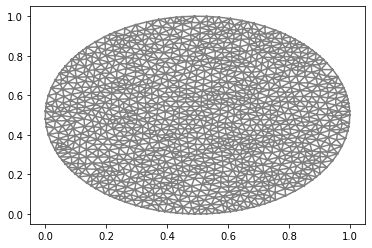

In [3]:
dl.plot(mesh)

In [4]:
# rows = rows_true
# cols = cols_true

num_neighbors = 10

T = cKDTree(dof_coords)
_, jj = T.query(dof_coords, num_neighbors)

rows = np.outer(np.arange(jj.shape[0], dtype=int), np.ones(jj.shape[1], dtype=int)).reshape(-1)
cols = jj.reshape(-1)

nq = len(rows)

nq= 12640 np.size(Y)= 7584


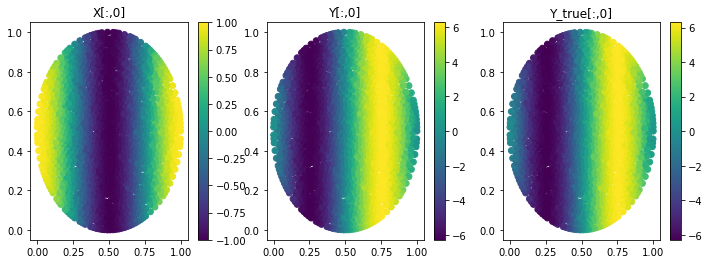

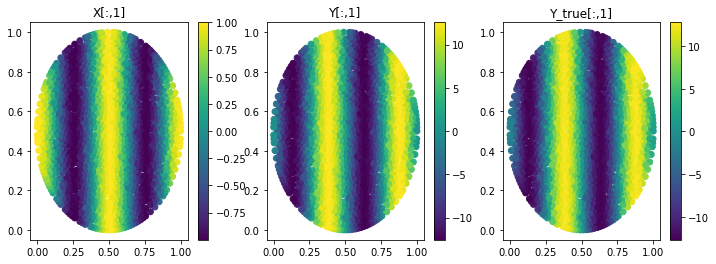

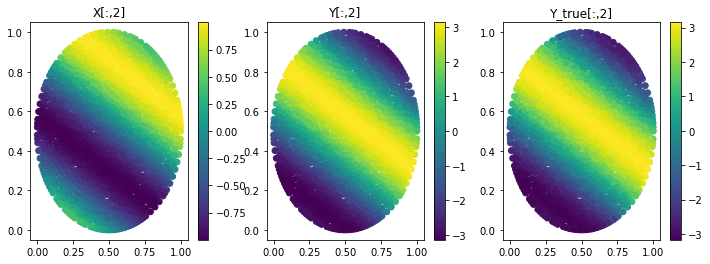

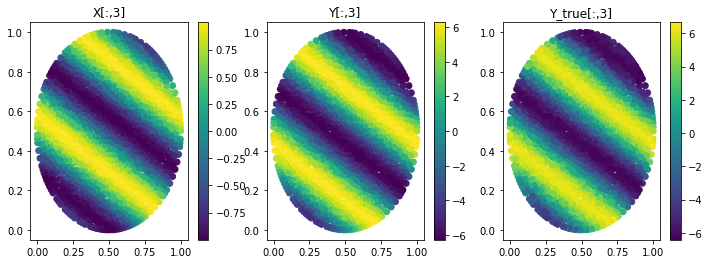

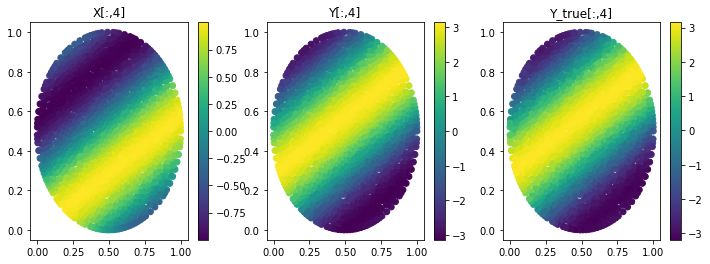

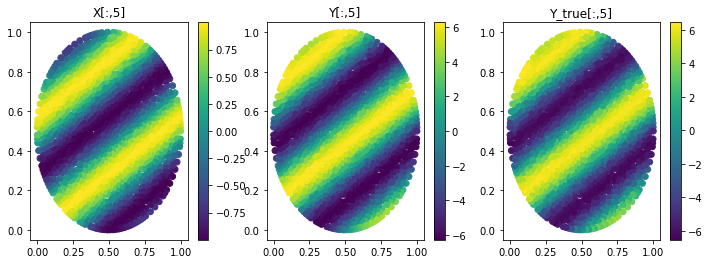

In [5]:
def complex_exponential(theta, omega):
    s = 2. * np.pi * omega * 1j
    vhat = np.array([np.cos(theta), -np.sin(theta)])
    return np.exp(s * np.dot(dof_coords, vhat))

def Dx_complex_exponential(theta, omega):
    s = 2. * np.pi * omega * 1j
    vhat = np.array([np.cos(theta), -np.sin(theta)])
    return s * vhat[0] * np.exp(s * np.dot(dof_coords, vhat))
    

num_thetas = 3

thetas = 2. * np.pi * np.arange(num_thetas) / num_thetas
omegas = np.array([1,2])

num_omegas = len(omegas)

X = np.zeros((V.dim(), num_thetas, num_omegas), dtype=complex)
Y = np.zeros((V.dim(), num_thetas, num_omegas), dtype=complex)
for ii in range(num_thetas):
    for jj in range(num_omegas):
        X[:,ii,jj] = complex_exponential(thetas[ii], omegas[jj])
        Y[:,ii,jj] = Dx_complex_exponential(thetas[ii], omegas[jj])

X = X.reshape((V.dim(), -1))
Y = Y.reshape((V.dim(), -1))

Y_true = solve_M(Dx_true * X)

for k in range(X.shape[1]):
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=X[:,k].real)
    plt.colorbar()
    plt.title('X[:,' + str(k) + ']')

    plt.subplot(132)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Y[:,k].real)
    plt.colorbar()
    plt.title('Y[:,' + str(k) + ']')

    plt.subplot(133)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Y_true[:,k].real)
    plt.colorbar()
    plt.title('Y_true[:,' + str(k) + ']')

print('nq=', nq, 'np.size(Y)=', np.size(Y))

In [6]:
def make_Dx_matrix(q):
    return sps.coo_matrix((q, (rows, cols)), shape=(V.dim(), V.dim()), dtype=complex).tocsr()

# Dx = make_Dx_matrix(q_true)

# z = np.random.randn(V.dim())
# err_make_Dx_matrix = np.linalg.norm(Dx * z - Dx_true * z) / np.linalg.norm(Dx_true * z)
# print('err_make_Dx_matrix=', err_make_Dx_matrix)

In [7]:
def Dx_dq_mode3_contraction(z):
    return sps.coo_matrix((z[cols], (rows, np.arange(nq))), shape=(V.dim(), nq), dtype=complex).tocsr()

z = np.random.randn(V.dim())

q1 = np.random.randn(nq)
Dx1 = make_Dx_matrix(q1)

s = 1e-7
dq = np.random.randn(nq)
q2 = q1 + s * dq

delta = Dx_dq_mode3_contraction(z) * dq

Dx2 = make_Dx_matrix(q2)

delta_diff = (Dx2 * z - Dx1 * z) / s

err_Dx_dq_mode3_contraction = np.linalg.norm(delta - delta_diff) / np.linalg.norm(delta_diff)
print('s=', s, ', err_Dx_dq_mode3_contraction=', err_Dx_dq_mode3_contraction)

s= 1e-07 , err_Dx_dq_mode3_contraction= 1.9638096725154526e-09


In [8]:
# a_reg = 1e-1
a_reg = 0.0

# MY_true = M * Y_true
MY_true = M * Y

def objective(q):
    Dx = make_Dx_matrix(q)
    Res = MY_true - Dx * X
    return 0.5 * np.linalg.norm(Res)**2 + 0.5 * a_reg * np.linalg.norm(q)**2

# J_true = objective(q_true)

# print('J_true=', J_true)

q1 = np.random.randn(nq)
J1 = objective(q1)
print('J1=', J1)

J1= 39104.309604501395


In [9]:
def gradient(q):
    Dx = make_Dx_matrix(q)
    Res = MY_true - Dx * X
    g = np.zeros(len(q))
    for k in range(len(g)):
        g[k] = -np.dot(Res[rows[k],:].conj(), X[cols[k],:]).real
    g = g + a_reg * q
    return g
    
g1 = gradient(q1)

s = 1e-8
dq = np.random.randn(nq)
q2 = q1 + s * dq

dJ = np.dot(g1, dq)

J2 = objective(q2)
dJ_diff = (J2 - J1) / s

err_grad = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
print('s=', s, ', err_grad=', err_grad)

s= 1e-08 , err_grad= 4.934782198833476e-07


In [10]:
def hessian():
    HH = list()
    for k in range(X.shape[1]):
        Jk = Dx_dq_mode3_contraction(X[:,k])
        Hk = Jk.H * Jk
        HH.append(Hk.real)
    
    H = HH[0]
    for Hk in HH[1:]:
        H += Hk
        
    H = H + a_reg * sps.eye(H.shape[1])
        
    return H

q1 = np.random.randn(nq)
g1 = gradient(q1)
H = hessian()

H_sparsity_fraction = H.nnz / np.prod(H.shape)
print('H_sparsity_fraction=', H_sparsity_fraction)

s = 1e-7
dq = np.random.randn(nq)
q2 = q1 + s * dq
g2 = gradient(q2)

dg = H * dq

dg_diff = (g2 - g1) / s

err_hessian = np.linalg.norm(dg - dg_diff) / np.linalg.norm(dg_diff)

print('s=', s, ', err_hessian=', err_hessian)

H_sparsity_fraction= 0.0007911392405063291
s= 1e-07 , err_hessian= 1.3008250135781414e-09


In [11]:
g0 = gradient(np.zeros(nq))
q = spla.spsolve(H, -g0)

# err_q = np.linalg.norm(q_true - q) / np.linalg.norm(q_true)
# print('err_q=', err_q)

In [12]:
# np.array([q, q_true]).T
q

array([-0.06155117,  0.04023118,  0.04108318, ...,  0.01074051,
       -0.00197683,  0.00099899])

err_Dx= 0.057522853919332075


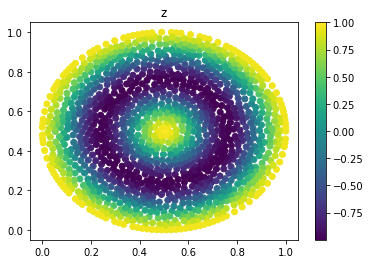

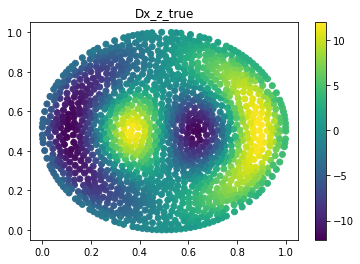

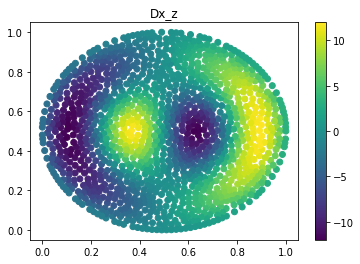

In [13]:
Dx = make_Dx_matrix(q)

z = np.cos(12 * np.linalg.norm(dof_coords - 0.5, axis=1))

Dx_z_true = solve_M(Dx_true.real * z).real
Dx_z = solve_M(Dx.real * z).real

err_Dx = np.linalg.norm(Dx_z_true - Dx_z) / np.linalg.norm(Dx_z_true)
print('err_Dx=', err_Dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=z)
plt.title('z')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Dx_z_true)
# cl = plt.clim(-0.5, 0.5)
plt.title('Dx_z_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Dx_z)
plt.title('Dx_z')
# plt.clim(-0.5, 0.5)
plt.colorbar()